In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
from visual_behavior.data_access import loading as loading

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [4]:
import visual_behavior.visualization.utils as utils

import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

### load experiments_table from cache

In [5]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)
# print(cache_dir)

In [6]:
experiments_table = loading.get_platform_paper_experiment_table()
print(len(experiments_table))

1249


#### add useful columns

In [7]:
experiments_table = utilities.add_cell_type_column(experiments_table)
experiments_table = utilities.add_experience_exposure_column(experiments_table)
experiments_table = utilities.add_binned_depth_column(experiments_table)

### get useful info

In [8]:
experience_level = np.sort(experiments_table.experience_level.unique())
print(experience_level)

['Familiar' 'Novel 1' 'Novel >1']


In [9]:
exposures = np.sort(experiments_table.experience_exposure.unique())
print(exposures)

['Familiar 0' 'Familiar 1' 'Familiar 2' 'Familiar 3' 'Familiar > 3'
 'Novel 0' 'Novel 1' 'Novel 2' 'Novel 3' 'Novel > 3']


In [10]:
cell_types = np.sort(experiments_table.cell_type.unique() )
print(cell_types)

['Excitatory' 'Sst Inhibitory' 'Vip Inhibitory']


### get multi_session_df

In [11]:
%%time

# set various params
df_name = 'trials_response_df'
conditions = ['cell_specimen_id', 'stimulus_change', 'epoch']
use_events = True
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# keep changes only
multi_session_df = multi_session_df[multi_session_df.stimulus_change==True]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))

# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

multi_session_df = multi_session_df.reset_index()

1305
1249
1249
Wall time: 1min 11s


### get rid of weird 7th epoch

In [12]:
multi_session_df = multi_session_df[multi_session_df.epoch!=6] # its the 6th index


### add experience_epoch column

In [13]:
def merge_experience_epoch(row):
    return row.experience_level+' epoch '+str(int(row.epoch)+1)

In [14]:
multi_session_df['experience_epoch'] = multi_session_df[['experience_level', 'epoch']].apply(axis=1, func=merge_experience_epoch)

experience_epoch = np.sort(multi_session_df.experience_epoch.unique())
experience_epoch

array(['Familiar epoch 1', 'Familiar epoch 2', 'Familiar epoch 3',
       'Familiar epoch 4', 'Familiar epoch 5', 'Familiar epoch 6',
       'Novel 1 epoch 1', 'Novel 1 epoch 2', 'Novel 1 epoch 3',
       'Novel 1 epoch 4', 'Novel 1 epoch 5', 'Novel 1 epoch 6',
       'Novel >1 epoch 1', 'Novel >1 epoch 2', 'Novel >1 epoch 3',
       'Novel >1 epoch 4', 'Novel >1 epoch 5', 'Novel >1 epoch 6'],
      dtype=object)

### before any filtering

In [15]:
df = multi_session_df.copy()
df = df.reset_index()

In [16]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  41                    280   
               Novel 1                   36                     71   
               Novel >1                  41                    196   
Sst Inhibitory Familiar                  19                    144   
               Novel 1                   15                     37   
               Novel >1                  19                    107   
Vip Inhibitory Familiar                  22                    217   
               Novel 1                   17                     47   
               Novel >1                  22                    150   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            88               18782  
               Novel 1                             71                9225  
               Novel >1                            88               15705  
Sst Inhibitory Familiar                            46                 738  
               Novel 1                             37                 414  
               Novel >1                            45                 678  
Vip Inhibitory Familiar                            69                1852  
               Novel 1                             47                 792  
               Novel >1                            66                1547

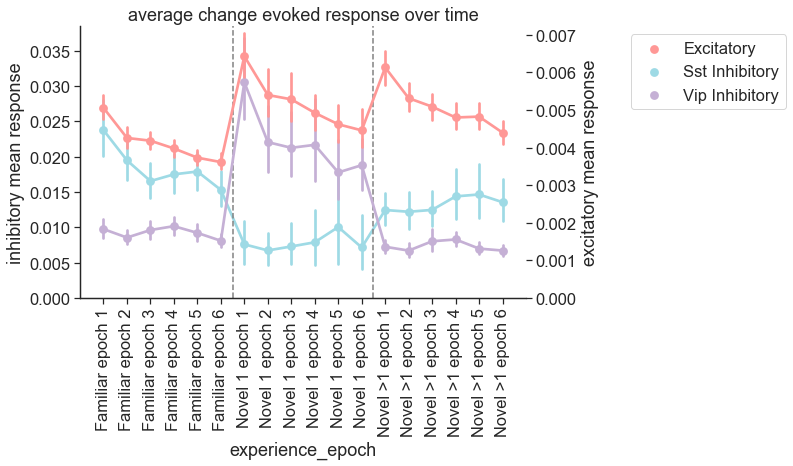

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to containers with all 3 experience levels

In [18]:
df = multi_session_df.copy()
df = utilities.limit_to_containers_with_all_experience_levels(df)

In [19]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  36                    227   
               Novel 1                   36                     71   
               Novel >1                  36                    142   
Sst Inhibitory Familiar                  15                    115   
               Novel 1                   15                     37   
               Novel >1                  15                     85   
Vip Inhibitory Familiar                  17                    138   
               Novel 1                   17                     44   
               Novel >1                  17                     96   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            71               15268  
               Novel 1                             71                9225  
               Novel >1                            71               11962  
Sst Inhibitory Familiar                            37                 598  
               Novel 1                             37                 414  
               Novel >1                            37                 548  
Vip Inhibitory Familiar                            44                1233  
               Novel 1                             44                 742  
               Novel >1                            44                1067

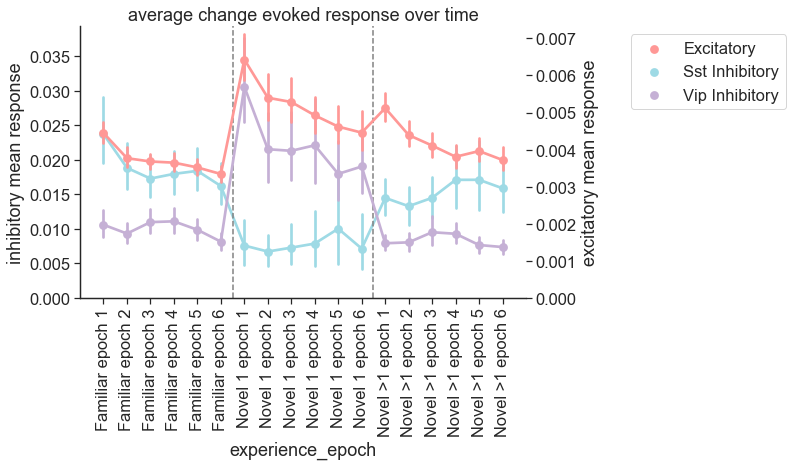

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to containers with all 3 levels for closest active sessions

In [21]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_containers_with_all_experience_levels(df)

In [22]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  15                     30   
               Novel 1                   15                     30   
               Novel >1                  15                     30   
Vip Inhibitory Familiar                  17                     42   
               Novel 1                   17                     42   
               Novel >1                  17                     42   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                7302  
               Novel 1                             62                7974  
               Novel >1                            62                7544  
Sst Inhibitory Familiar                            30                 321  
               Novel 1                             30                 337  
               Novel >1                            30                 320  
Vip Inhibitory Familiar                            42                 794  
               Novel 1                             42                 718  
               Novel >1                            42                 765

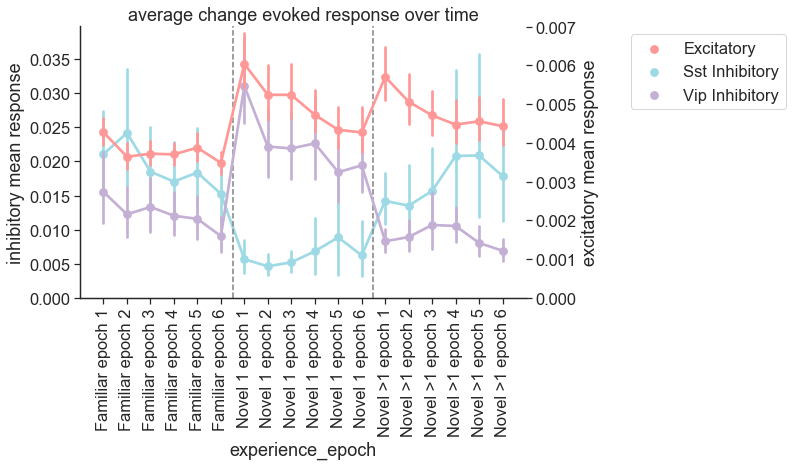

In [23]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to matched cells in all 3

In [24]:
df = multi_session_df.copy()
df = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(df)

In [25]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  36                    226   
               Novel 1                   36                     71   
               Novel >1                  36                    142   
Sst Inhibitory Familiar                  15                    112   
               Novel 1                   15                     36   
               Novel >1                  15                     84   
Vip Inhibitory Familiar                  17                    137   
               Novel 1                   17                     44   
               Novel >1                  17                     96   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            71                5695  
               Novel 1                             71                5695  
               Novel >1                            71                5695  
Sst Inhibitory Familiar                            36                 292  
               Novel 1                             36                 292  
               Novel >1                            36                 292  
Vip Inhibitory Familiar                            44                 540  
               Novel 1                             44                 540  
               Novel >1                            44                 540

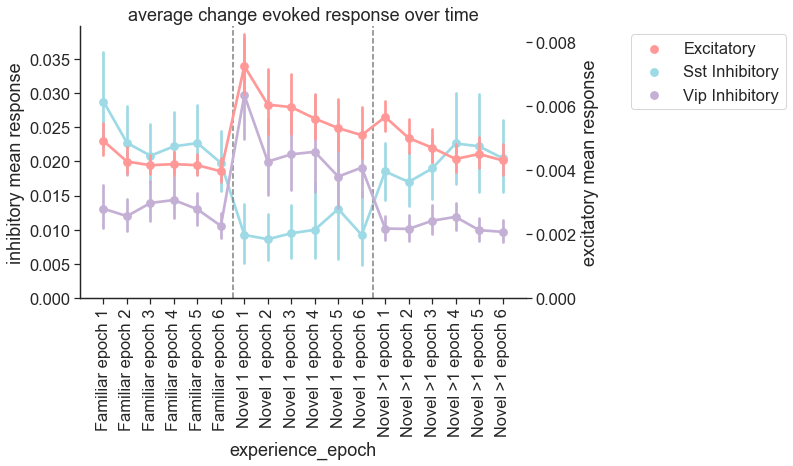

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### limit to matched cells in closest active sessions

In [27]:
df = multi_session_df.copy()
df = utilities.limit_to_last_familiar_second_novel_active(df)
df = utilities.limit_to_cell_specimen_ids_matched_in_all_experience_levels(df)

In [28]:
utilities.count_mice_expts_containers_cells(df)

n_mouse_id  n_ophys_experiment_id  \
cell_type      experience_level                                      
Excitatory     Familiar                  34                     62   
               Novel 1                   34                     62   
               Novel >1                  34                     62   
Sst Inhibitory Familiar                  14                     28   
               Novel 1                   14                     28   
               Novel >1                  14                     28   
Vip Inhibitory Familiar                  17                     41   
               Novel 1                   17                     41   
               Novel >1                  17                     41   

                                 n_ophys_container_id  n_cell_specimen_id  
cell_type      experience_level                                            
Excitatory     Familiar                            62                3326  
               Novel 1                             62                3326  
               Novel >1                            62                3326  
Sst Inhibitory Familiar                            28                 200  
               Novel 1                             28                 200  
               Novel >1                            28                 200  
Vip Inhibitory Familiar                            41                 415  
               Novel 1                             41                 415  
               Novel >1                            41                 415

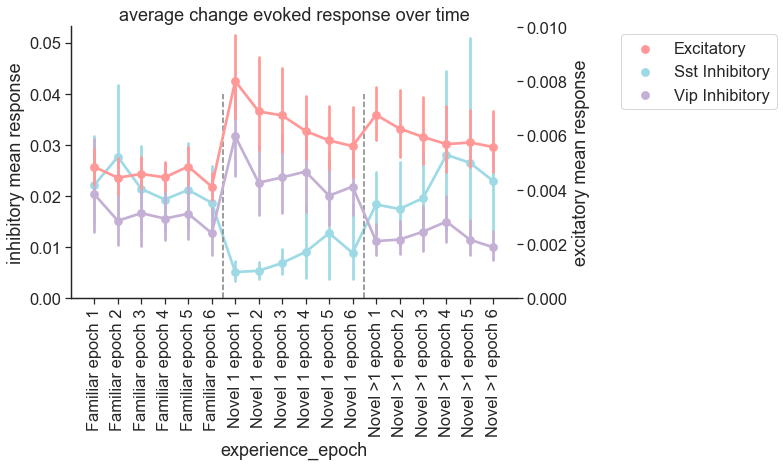

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=df[df.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=df[df.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.04, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.04, color='gray', linestyle='--')

### for V1 or LM only 

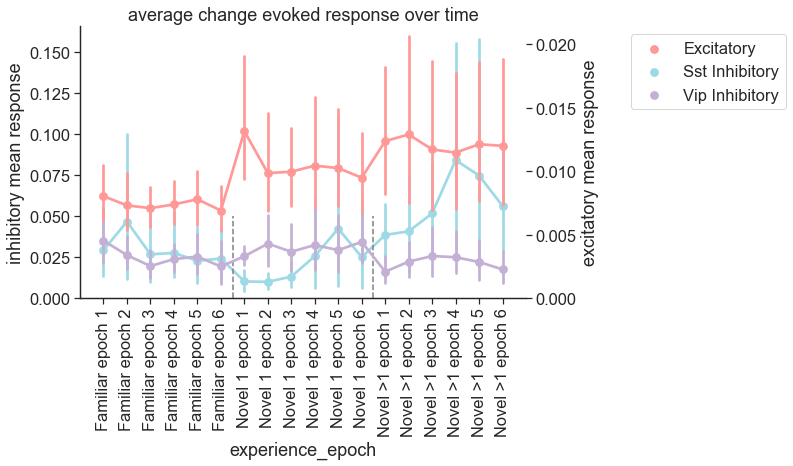

In [30]:
data = df.copy()
data = data[data.targeted_structure=='VISl']


fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=data[data.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=data[data.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.05, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.05, color='gray', linestyle='--')

### restrict to mesoscope

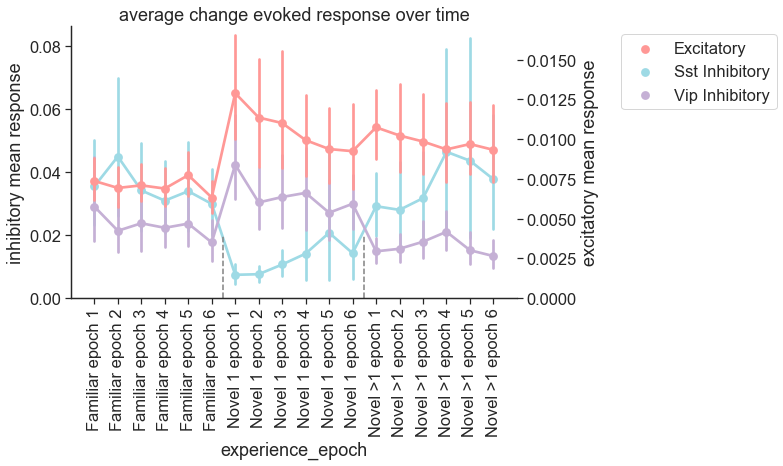

In [31]:
data = df.copy()
data = data[data.project_code=='VisualBehaviorMultiscope']


fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
cre_line_colors = utils.get_cre_line_colors()
ax2 = sns.pointplot(data=data[data.cell_type==cell_types[0]], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors, hue_order=cell_types, ax=ax2)
ax2.set_ylabel('excitatory mean response')
ax2.legend(bbox_to_anchor=(1.6,1))
ax2.set_ylim(ymin=0)
ax = sns.pointplot(data=data[data.cell_type.isin(cell_types[1:])], x='experience_epoch', y='mean_response', hue='cell_type', 
                   order=experience_epoch, palette=cre_line_colors[1:], hue_order=cell_types[1:], ax=ax)
ax.set_ylabel('inhibitory mean response')
ax.set_ylim(ymin=0)
# ax.legend(bbox_to_anchor=(1.2,1))
ax.get_legend().remove()
ax.set_xticklabels(experience_epoch, rotation=90);
ax.set_title('average change evoked response over time')
ax.vlines(x=5.5, ymin=0, ymax=0.02, color='gray', linestyle='--')
ax.vlines(x=11.5, ymin=0, ymax=0.02, color='gray', linestyle='--')

### heatmap of all mice epoch level responses

In [32]:
df = multi_session_df.copy()

In [33]:
df = df.sort_values(by=['experience_level', 'mouse_id'])

In [34]:
multi_session_df[multi_session_df.ophys_container_id==1018028218].experience_level.unique()

array(['Familiar', 'Novel 1', 'Novel >1'], dtype=object)

In [35]:
df[df.ophys_container_id==1018028218].experience_level.unique()

array(['Familiar', 'Novel 1', 'Novel >1'], dtype=object)

In [36]:
data = df[df.epoch!=6].copy() # get rid of weird last epoch
data = data.groupby(['experience_level', 'epoch', 'cell_type', 'mouse_id', ]).mean()[['mean_response']].unstack(level=[0,1])
data.columns = data.columns.droplevel()

#### by mouse_id

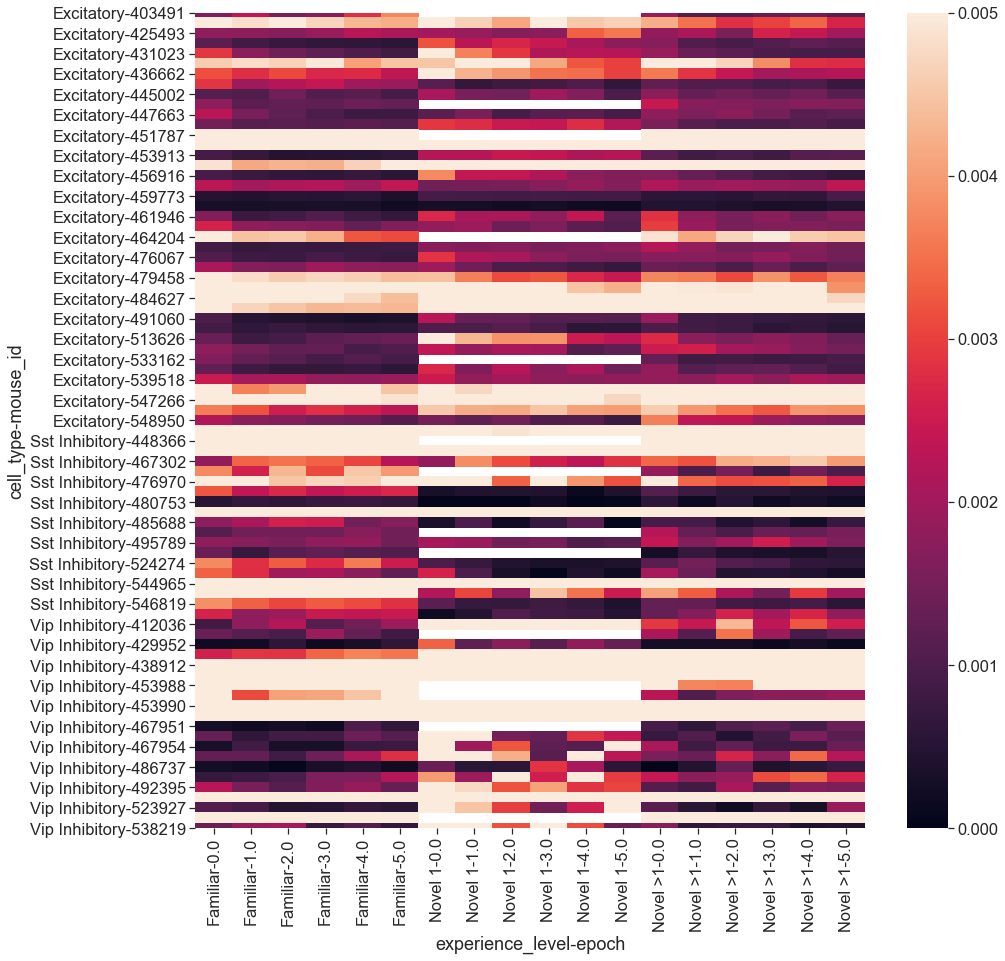

In [37]:
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(data, vmin=0, vmax=0.005, ax=ax)

#### by area and depth and mouse

In [38]:
df = df.sort_values(by=['experience_level', 'mouse_id', 'targeted_structure', 'depth', ])

In [39]:
np.sort(df.experience_level.unique())

array(['Familiar', 'Novel 1', 'Novel >1'], dtype=object)

In [40]:
df[df.ophys_container_id==1018028218]

index  cell_specimen_id  stimulus_change  epoch  mean_response  \
39205    39205        1086564116             True    0.0       0.027243   
39206    39206        1086564116             True    1.0       0.000000   
39207    39207        1086564116             True    2.0       0.000000   
39208    39208        1086564116             True    3.0       0.027224   
39209    39209        1086564116             True    4.0       0.051770   
...        ...               ...              ...    ...            ...   
280143  280143        1086577999             True    1.0       0.000000   
280144  280144        1086577999             True    2.0       0.000000   
280145  280145        1086577999             True    3.0       0.000000   
280146  280146        1086577999             True    4.0       0.000000   
280147  280147        1086577999             True    5.0       0.000000   

        sem_response                                         mean_trace  \
39205       0.018453  [0.0, 0.0, 0.0, 0.0, 0.0, 0.06016995609714393,...   
39206       0.000000  [0.0, 0.1888737706547727, 0.0, 0.0, 0.0, 0.0, ...   
39207       0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0996912056430...   
39208       0.026598  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39209       0.034516  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0438006586799...   
...              ...                                                ...   
280143      0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280144      0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280145      0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280146      0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280147      0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                sem_trace  \
39205   [0.0, 0.0, 0.0, 0.0, 0.0, 0.05890307829563513,...   
39206   [0.0, 0.13242262307734362, 0.0, 0.0, 0.0, 0.0,...   
39207   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0957802122613...   
39208   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
39209   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0425665889542...   
...                                                   ...   
280143  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280144  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280146  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
280147  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         trace_timestamps  \
39205   [-4.941422091574936, -4.848187712488621, -4.75...   
39206   [-4.941422091574937, -4.848187712488619, -4.75...   
39207   [-4.941422091574937, -4.848187712488619, -4.75...   
39208   [-4.941422091574936, -4.84818771248862, -4.754...   
39209   [-4.941422091574937, -4.84818771248862, -4.754...   
...                                                   ...   
280143  [-4.941524531767727, -4.848288219847579, -4.75...   
280144  [-4.941524531767727, -4.848288219847579, -4.75...   
280145  [-4.941524531767727, -4.84828821984758, -4.755...   
280146  [-4.941524531767727, -4.848288219847579, -4.75...   
280147  [-4.941524531767727, -4.8482882198475785, -4.7...   

                                           mean_responses  ...  area_depth  \
39205   [0.0, 0.0, 0.33680440442527027, 0.0, 0.0, 0.0,...  ...    VISl_289   
39206   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    VISl_289   
39207   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    VISl_289   
39208   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59893644...  ...    VISl_289   
39209   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    VISl_289   
...                                                   ...  ...         ...   
280143  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    VISl_289   
280144  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...    VISl_289   
280145  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [41]:
data

experience_level         Familiar                                          \
epoch                         0.0       1.0       2.0       3.0       4.0   
cell_type      mouse_id                                                     
Excitatory     403491    0.001663  0.002378  0.001560  0.001729  0.002819   
               412366    0.005168  0.004827  0.005482  0.004693  0.004330   
               425493    0.001815  0.001790  0.001717  0.001911  0.002247   
               425496    0.001173  0.000852  0.000727  0.000654  0.000632   
               431023    0.002899  0.001740  0.001404  0.001243  0.001033   
...                           ...       ...       ...       ...       ...   
Vip Inhibitory 523922    0.019722  0.023676  0.017366  0.028259  0.018054   
               523927    0.001049  0.000916  0.000484  0.000489  0.000667   
               528097    0.007565  0.009342  0.011666  0.011392  0.017566   
               538219    0.001353  0.001907  0.002036  0.000741  0.001045   
               544261    0.003675  0.002087  0.001170  0.000784  0.000256   

experience_level                    Novel 1                                \
epoch                         5.0       0.0       1.0       2.0       3.0   
cell_type      mouse_id                                                     
Excitatory     403491    0.003757       NaN       NaN       NaN       NaN   
               412366    0.004204  0.005180  0.004643  0.004111  0.005397   
               425493    0.002111  0.002017  0.001876  0.001676  0.001744   
               425496    0.000577  0.003199  0.002295  0.002682  0.002446   
               431023    0.000864  0.005256  0.003687  0.002907  0.002155   
...                           ...       ...       ...       ...       ...   
Vip Inhibitory 523922    0.013572  0.030730  0.027051  0.021518  0.019497   
               523927    0.000582  0.007070  0.004488  0.002980  0.001459   
               528097    0.008799       NaN       NaN       NaN       NaN   
               538219    0.000648  0.008303  0.006014  0.003172  0.005519   
               544261    0.000603  0.006603  0.004896  0.007660  0.011888   

experience_level                             Novel >1                      \
epoch                         4.0       5.0       0.0       1.0       2.0   
cell_type      mouse_id                                                     
Excitatory     403491         NaN       NaN  0.001898  0.001081  0.001050   
               412366    0.004540  0.004661  0.004201  0.003509  0.002829   
               425493    0.003332  0.003583  0.001836  0.002090  0.001578   
               425496    0.002087  0.001753  0.001692  0.001051  0.000925   
               431023    0.002259  0.002245  0.001899  0.001350  0.001203   
...                           ...       ...       ...       ...       ...   
Vip Inhibitory 523922    0.016453  0.020861  0.009982  0.021960  0.023999   
               523927    0.002542  0.005263  0.001145  0.000563  0.000220   
               528097         NaN       NaN  0.011040  0.005489  0.007738   
               538219    0.003137  0.001326  0.001690  0.000610  0.000721   
               544261    0.009363  0.008516  0.003853  0.003554  0.001755   

experience_level                                       
epoch                         3.0       4.0       5.0  
cell_type      mouse_id                                
Excitatory     403491    0.001323  0.001401  0.001136  
               412366    0.003036  0.003375  0.002662  
               425493    0.002619  0.002435  0.002033  
               425496    0.001090  0.001221  0.001126  
               431023    0.001014  0.000920  0.000942  
...                           ...       ...       ...  
Vip Inhibitory 523922    0.025587  0.012521  0.008411  
               523927    0.000668  0.000331  0.001909  
               528097    0.007793  0.006658  0.009592  
               538219    0.000718  0.000375  0.000462  
               544261    0.002519  

In [42]:
data = df[df.epoch!=6].copy() # get rid of weird last epoch
data = data.groupby(['experience_level', 'epoch', 'cell_type', 'mouse_id', ]).mean()[['mean_response']].unstack(level=[0,1])
data.columns = data.columns.droplevel()

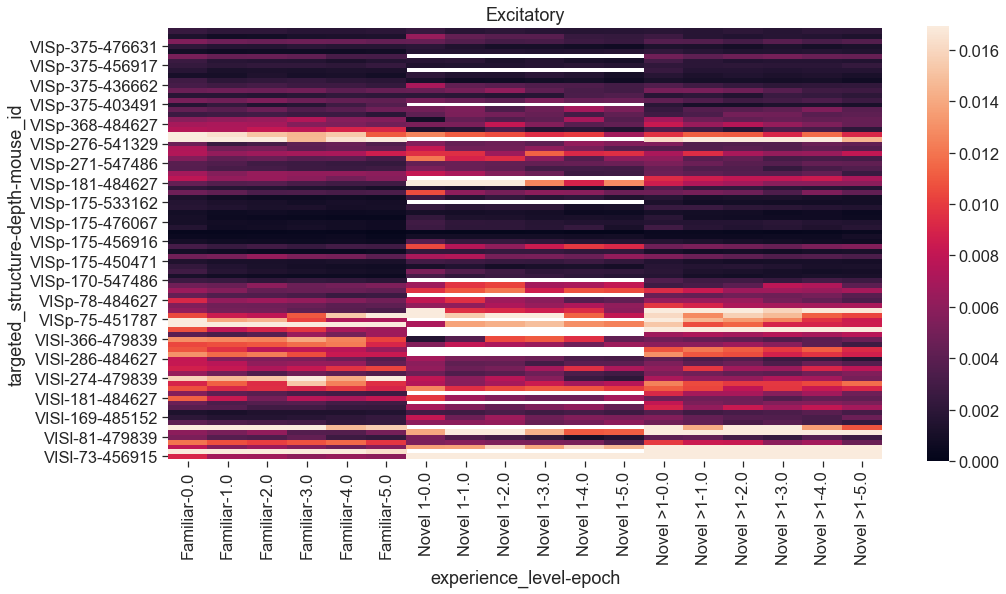

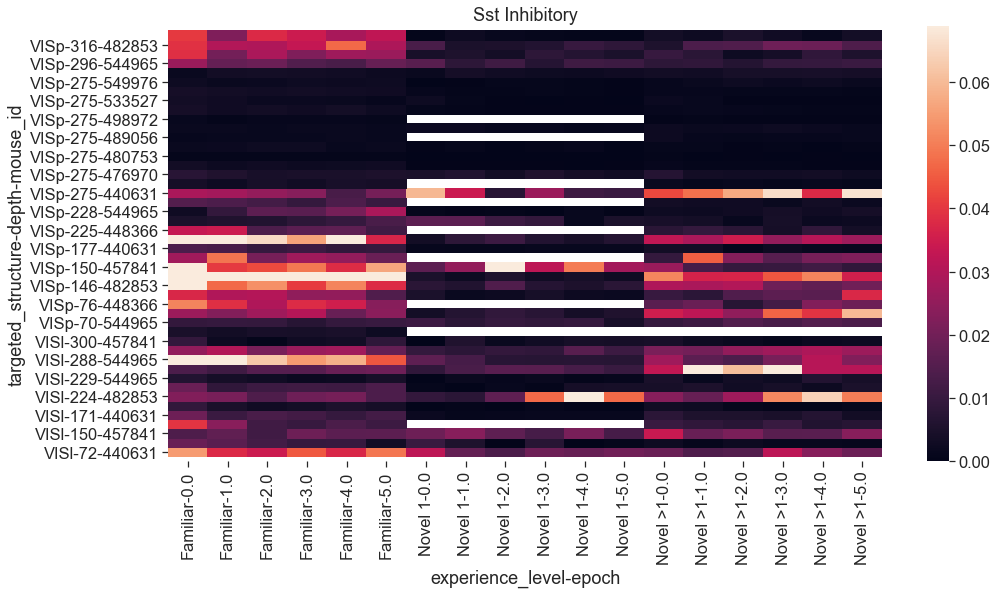

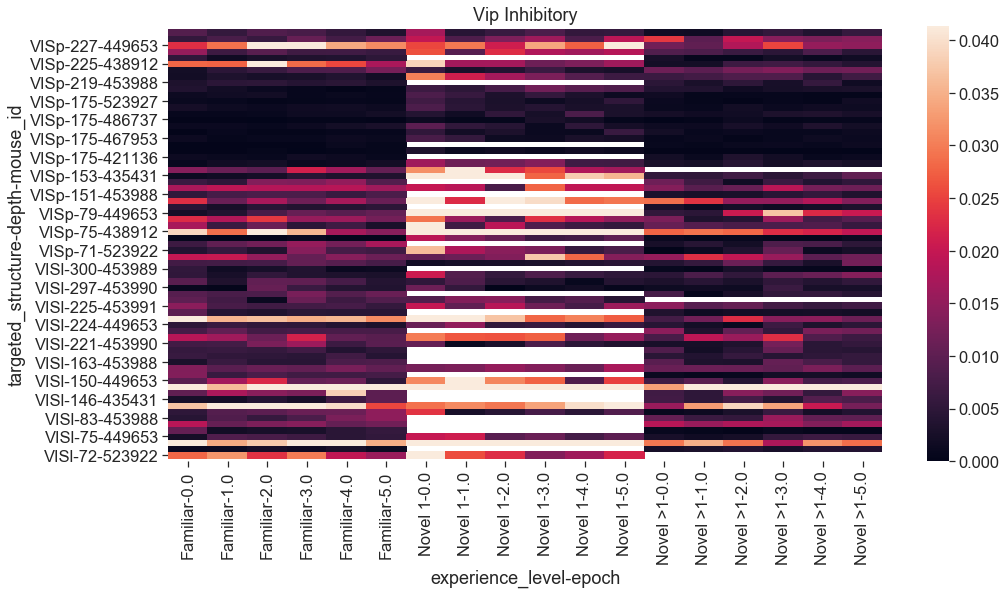

In [43]:
conditions = ['experience_level', 'epoch', 'targeted_structure', 'depth', 'mouse_id', ]
for cell_type in cell_types:
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0,1])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

#### by area and depth, average over mice

In [44]:
experiments_table[(experiments_table.mouse_id==482853)&(experiments_table.targeted_structure=='VISl')&
                 (experiments_table.depth==350)]

Empty DataFrame
Columns: [equipment_name, full_genotype, mouse_id, reporter_line, driver_line, sex, age_in_days, cre_line, indicator, session_number, prior_exposures_to_session_type, prior_exposures_to_image_set, prior_exposures_to_omissions, ophys_session_id, behavior_session_id, ophys_container_id, project_code, imaging_depth, targeted_structure, date_of_acquisition, session_type, experience_level, passive, image_set, file_id, cell_type, depth, binned_depth, area_depth, area_binned_depth, first_novel, n_relative_to_first_novel, last_familiar, last_familiar_active, second_novel, second_novel_active, experience_exposure]
Index: []

[0 rows x 37 columns]

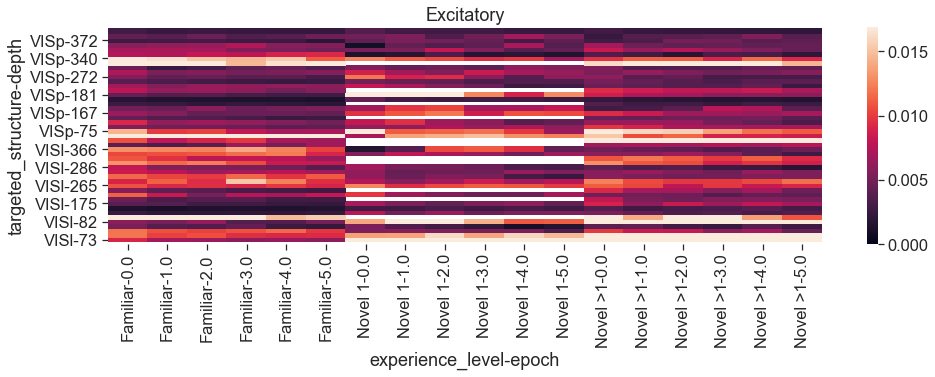

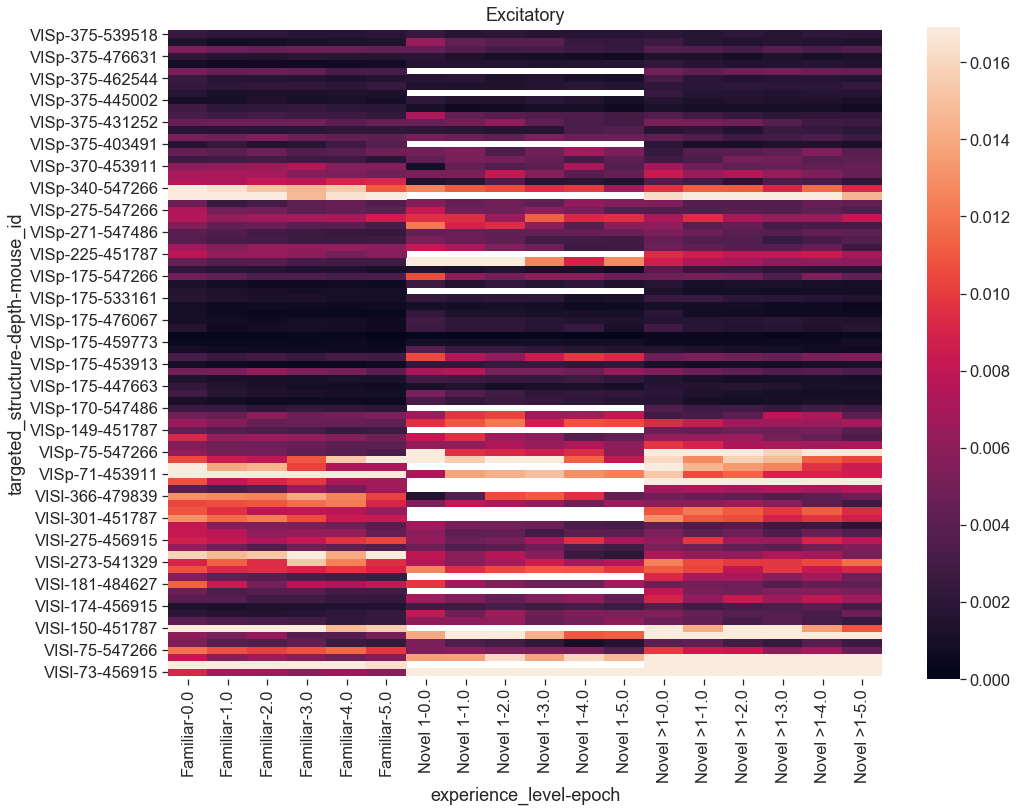

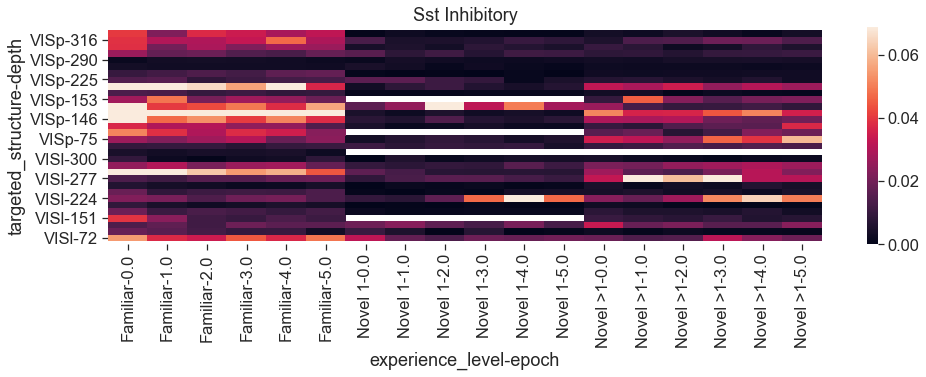

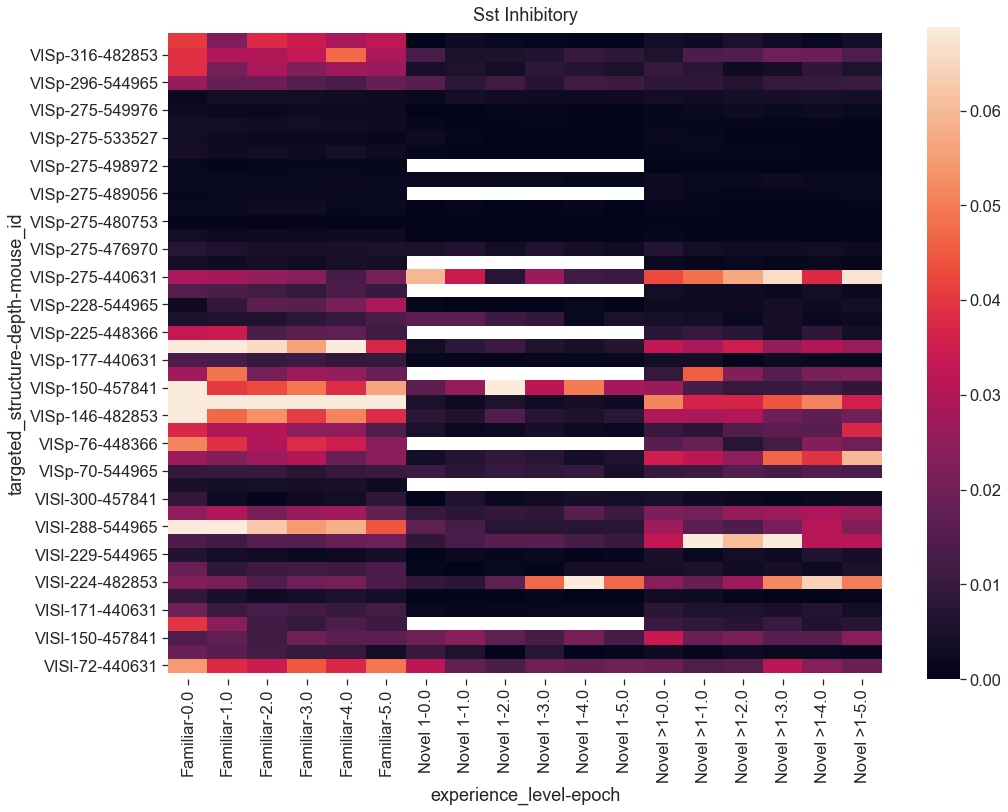

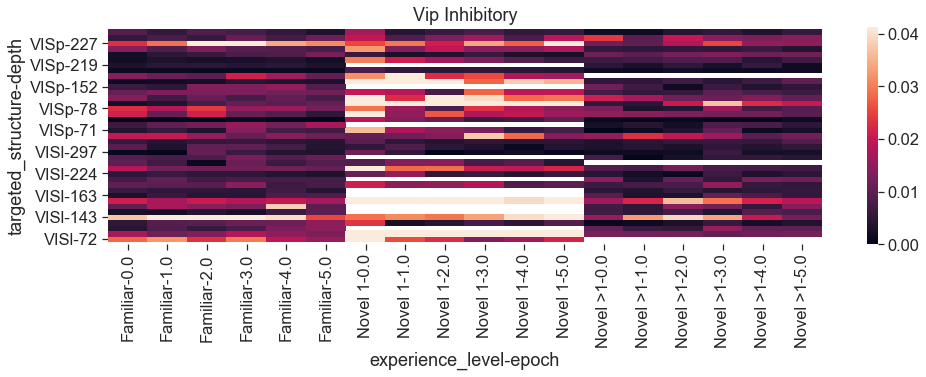

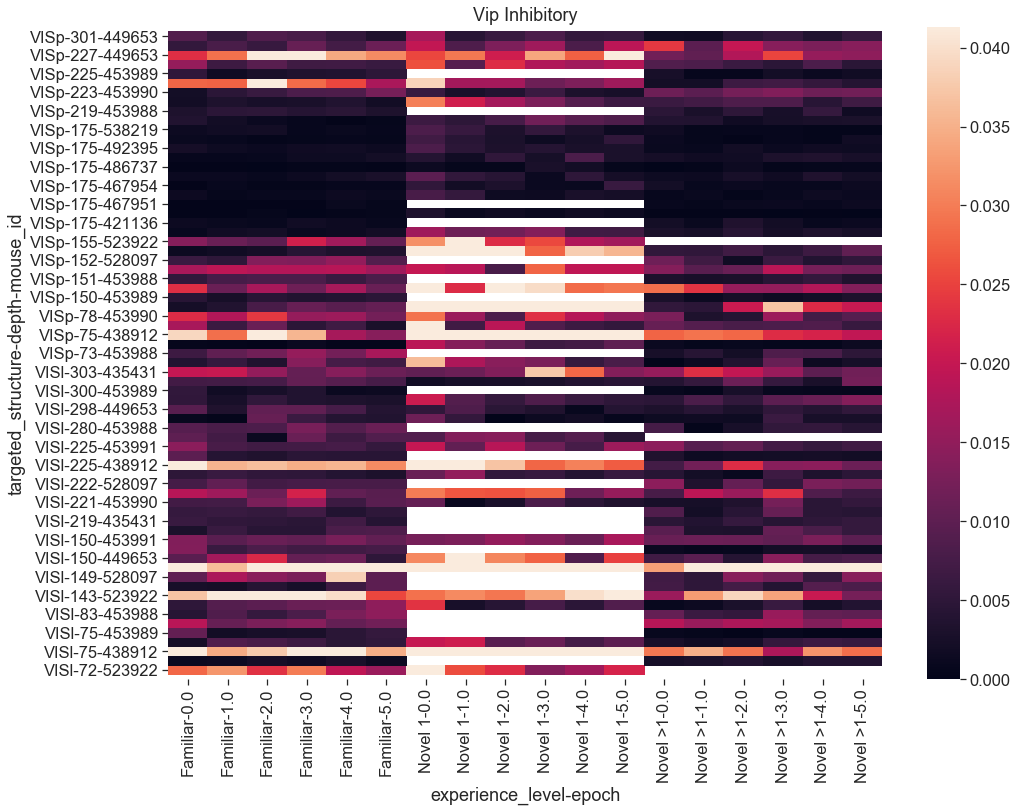

In [45]:
for cell_type in cell_types:
    # avg over mice
    conditions = ['experience_level', 'epoch', 'targeted_structure', 'depth']
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0,1])    
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)
    
    # all mice
    conditions = ['experience_level', 'epoch', 'targeted_structure', 'depth', 'mouse_id']
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0,1])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,12))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

#### median across mice

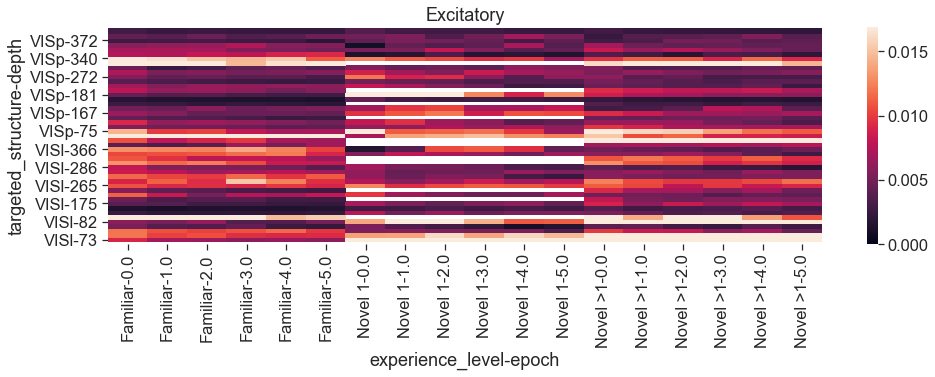

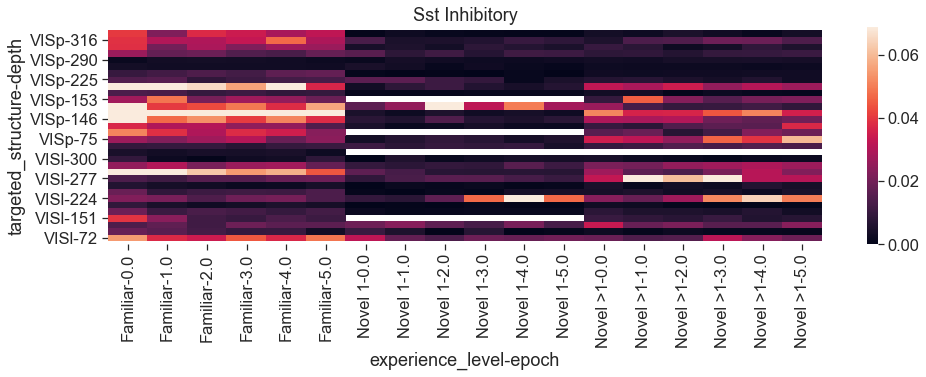

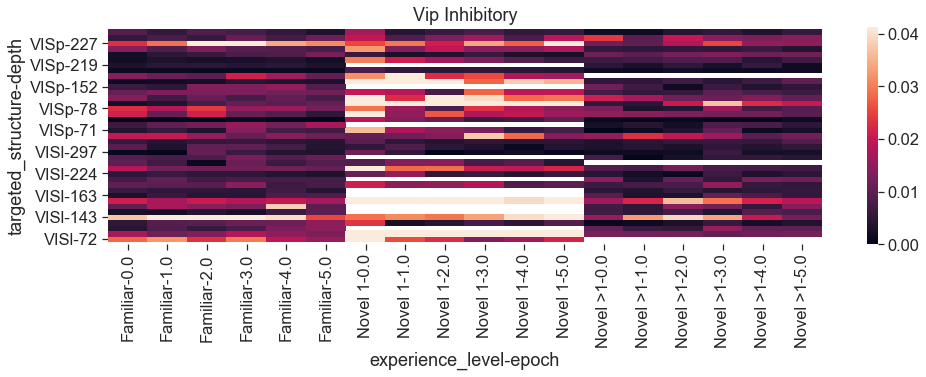

In [46]:
conditions = ['experience_level', 'epoch', 'targeted_structure', 'depth']
for cell_type in cell_types:
    # avg over mice
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0,1])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,4))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

#### sort by mouse and project code first

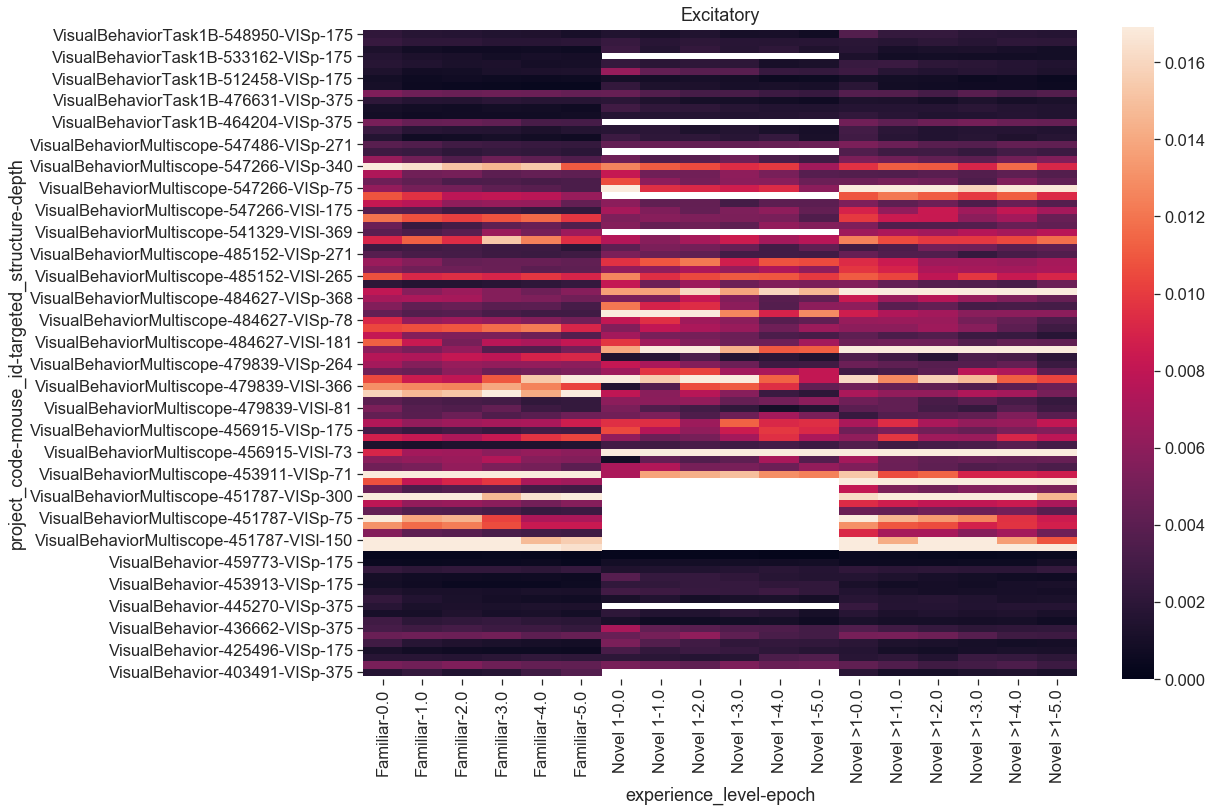

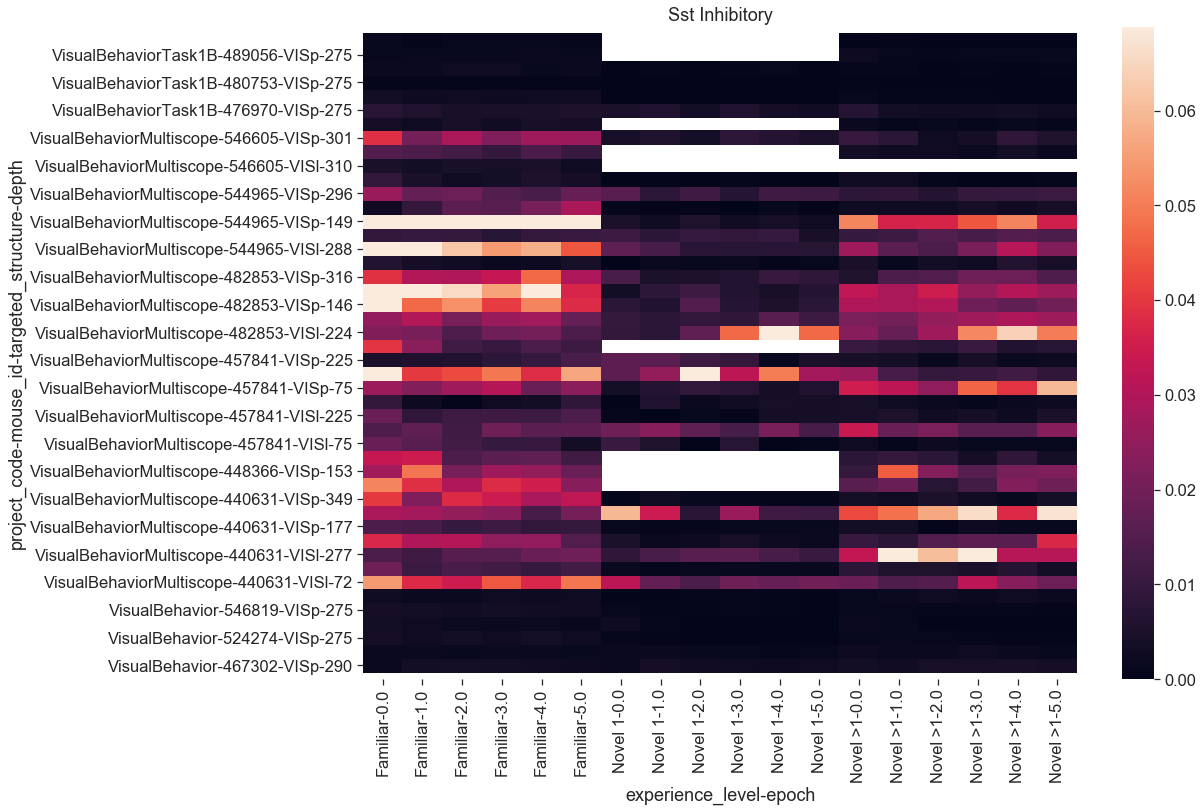

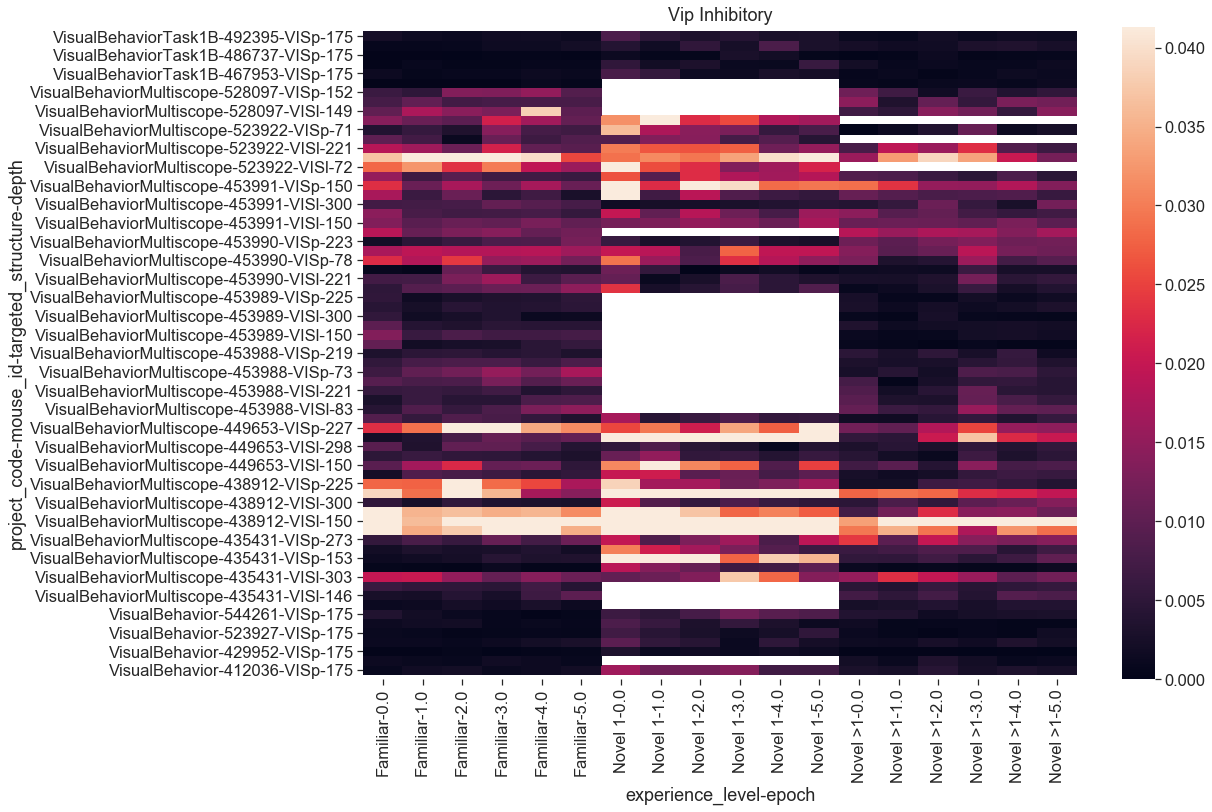

In [47]:
conditions = ['experience_level', 'epoch', 'project_code', 'mouse_id', 'targeted_structure', 'depth']
for cell_type in cell_types:
    # all mice
    data = df[df.epoch!=6].copy() # get rid of weird last epoch
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)    
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0, 1])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,12))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

### without epochs

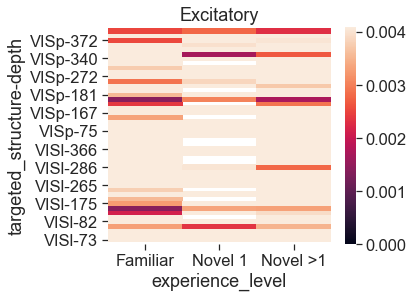

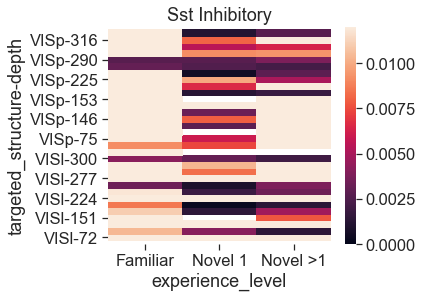

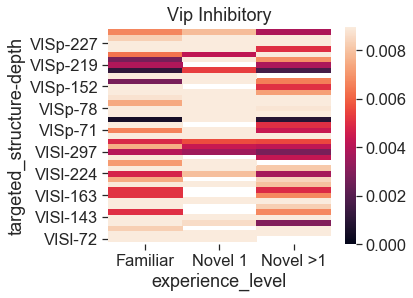

In [48]:
df = multi_session_df.copy()

conditions = ['experience_level', 'targeted_structure', 'depth']
for cell_type in cell_types:
    # avg over mice
    data = df.copy() 
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0])
    data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(df[df.cell_type==cell_type].mean_response.values, 80), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

    

In [49]:
%%time

# set various params
df_name = 'trials_response_df'
conditions = ['cell_specimen_id', 'stimulus_change', 'change_image_name']
use_events = True
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to changes, pref stim
multi_session_df = multi_session_df[(multi_session_df.stimulus_change==True)&
                                   (multi_session_df.pref_stim==True)]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))
# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

1941
1249
1249
Wall time: 4min 15s


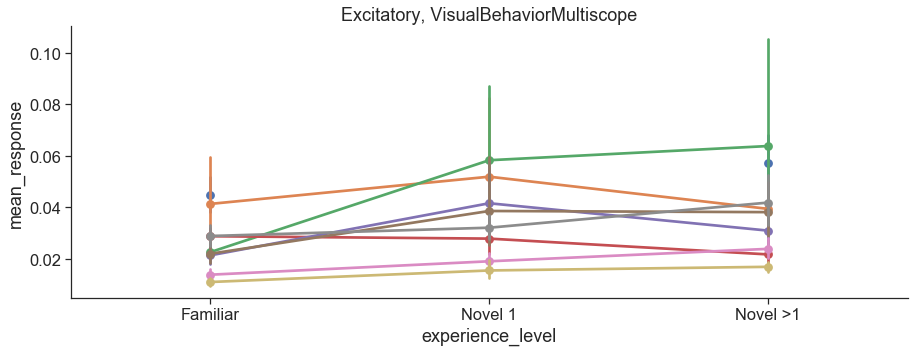

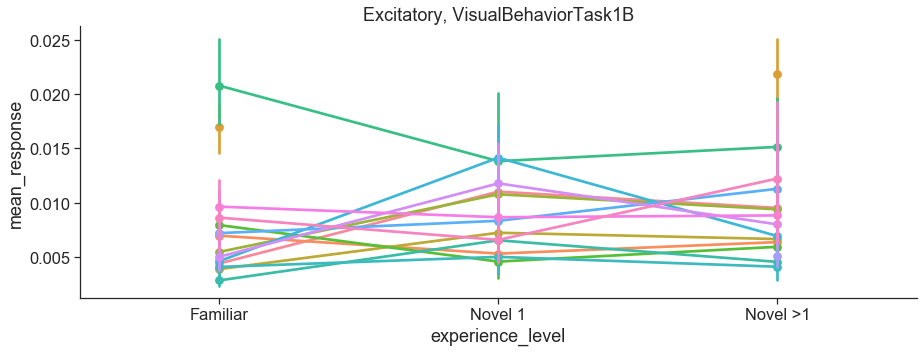

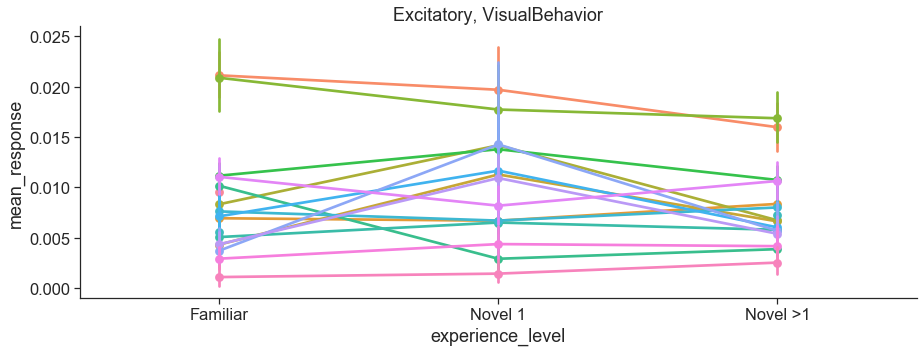

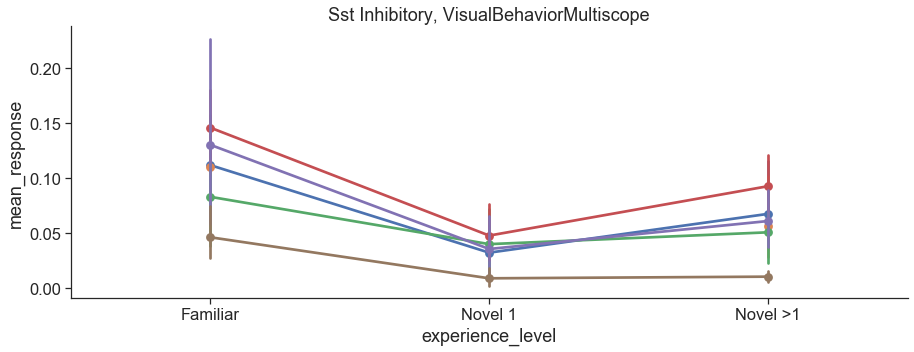

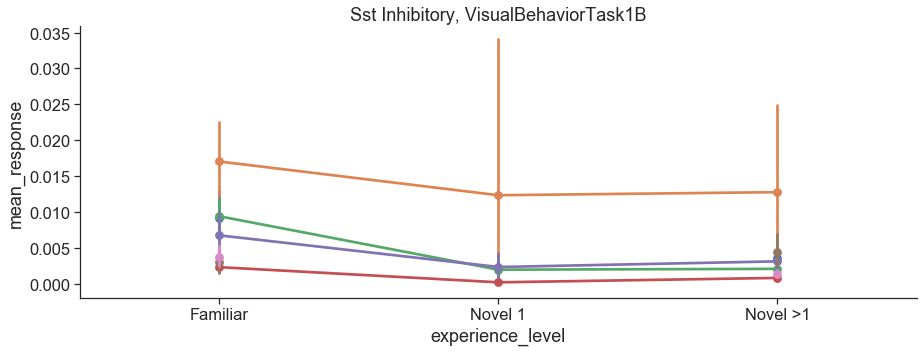

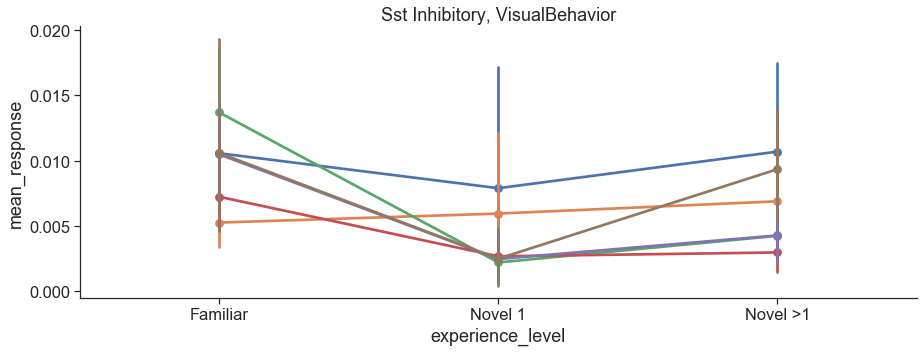

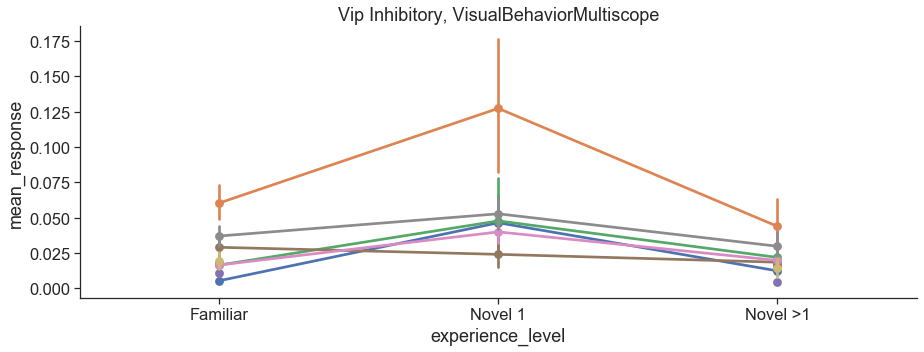

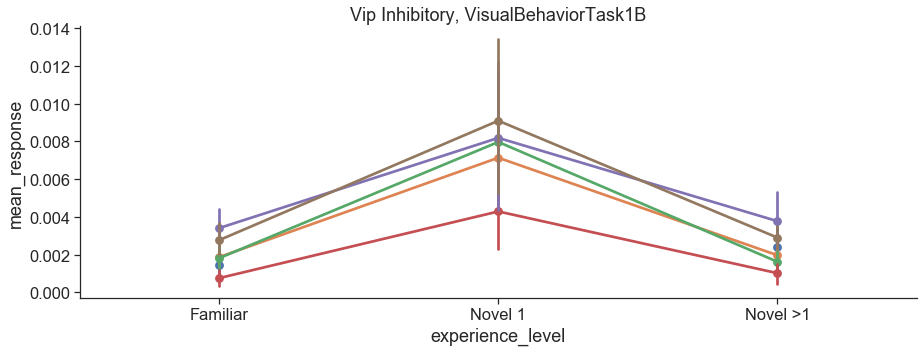

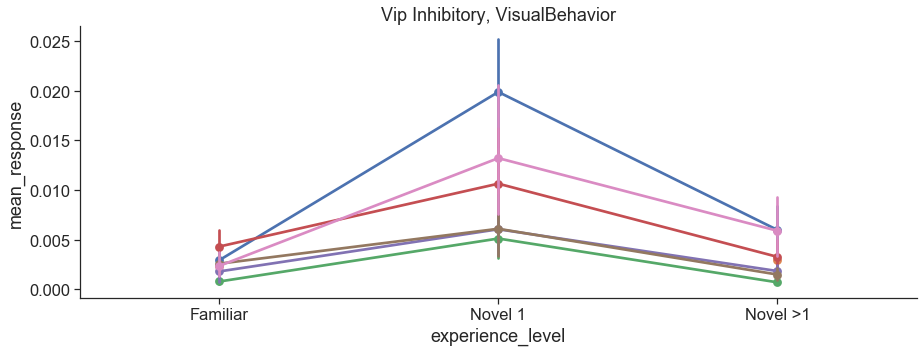

In [50]:
for cell_type in cell_types: 
    df = multi_session_df.copy()
    df = df[df.cell_type==cell_type]

    for project_code in df.project_code.unique():
        fig, ax = plt.subplots(figsize=(15,5))
        ax = sns.pointplot(data=df[df.project_code==project_code], x='experience_level', y='mean_response', hue='mouse_id', 
                           order=np.sort(df.experience_level.unique()), ax=ax)
        ax.get_legend().remove()
        ax.set_title(cell_type+', '+project_code)

In [51]:
multi_session_df.keys()

Index(['cell_specimen_id', 'stimulus_change', 'change_image_name',
       'mean_response', 'sem_response', 'mean_trace', 'sem_trace',
       'trace_timestamps', 'mean_responses', 'mean_baseline', 'sem_baseline',
       'pref_stim', 'peak_response', 'time_to_peak', 'fano_factor',
       'fraction_significant_p_value_gray_screen',
       'fraction_significant_p_value_omission',
       'fraction_significant_p_value_stimulus', 'reliability',
       'ophys_experiment_id', 'equipment_name', 'full_genotype', 'mouse_id',
       'reporter_line', 'driver_line', 'sex', 'age_in_days', 'cre_line',
       'indicator', 'session_number', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'ophys_session_id', 'behavior_session_id', 'ophys_container_id',
       'project_code', 'imaging_depth', 'targeted_structure',
       'date_of_acquisition', 'session_type', 'experience_level', 'passive',
       'image_set', 'file_id', 'cell_type', 'depth', 

In [52]:
data

experience_level          Familiar   Novel 1  Novel >1
targeted_structure depth                              
VISl               72     0.023609  0.023816       NaN
                   75     0.014027  0.068773  0.012071
                   83     0.008285       NaN  0.009857
                   142    0.013672  0.008609  0.002916
                   143    0.041487  0.037266  0.024078
                   146    0.005087       NaN  0.006770
                   149    0.015942       NaN  0.008300
                   150    0.018341  0.049827  0.023867
                   163    0.005140       NaN  0.006744
                   219    0.005142       NaN  0.004932
                   221    0.008939  0.014651  0.007981
                   222    0.007483       NaN  0.008447
                   224    0.004764  0.007944  0.003708
                   225    0.012613  0.027909  0.008149
                   275    0.007129  0.009569       NaN
                   280    0.008909       NaN  0.004287
                   297    0.004068  0.003573  0.002758
                   298    0.007527  0.004404  0.004218
                   300    0.004847  0.005616  0.005525
                   303    0.014688  0.016366  0.016015
VISp               71     0.006638  0.015817  0.004417
                   73     0.011328       NaN  0.005084
                   74     0.000523  0.014523  0.000896
                   75     0.012107  0.024662  0.012009
                   78     0.016568  0.018346  0.008833
                   79     0.007471  0.108448  0.018452
                   150    0.008769  0.038853  0.013367
                   151    0.011453  0.018866  0.007264
                   152    0.009886       NaN  0.005111
                   153    0.002764  0.046480  0.006576
                   155    0.013005  0.027858       NaN
                   175    0.001148  0.005348  0.001653
                   219    0.003876       NaN  0.003797
                   220    0.002678  0.019781  0.006905
                   223    0.006337  0.004216  0.011749
                   225    0.009578  0.018758  0.005044
                   227    0.035137  0.030365  0.015937
                   273    0.008321  0.013644  0.015858
                   301    0.006714  0.007881  0.003847

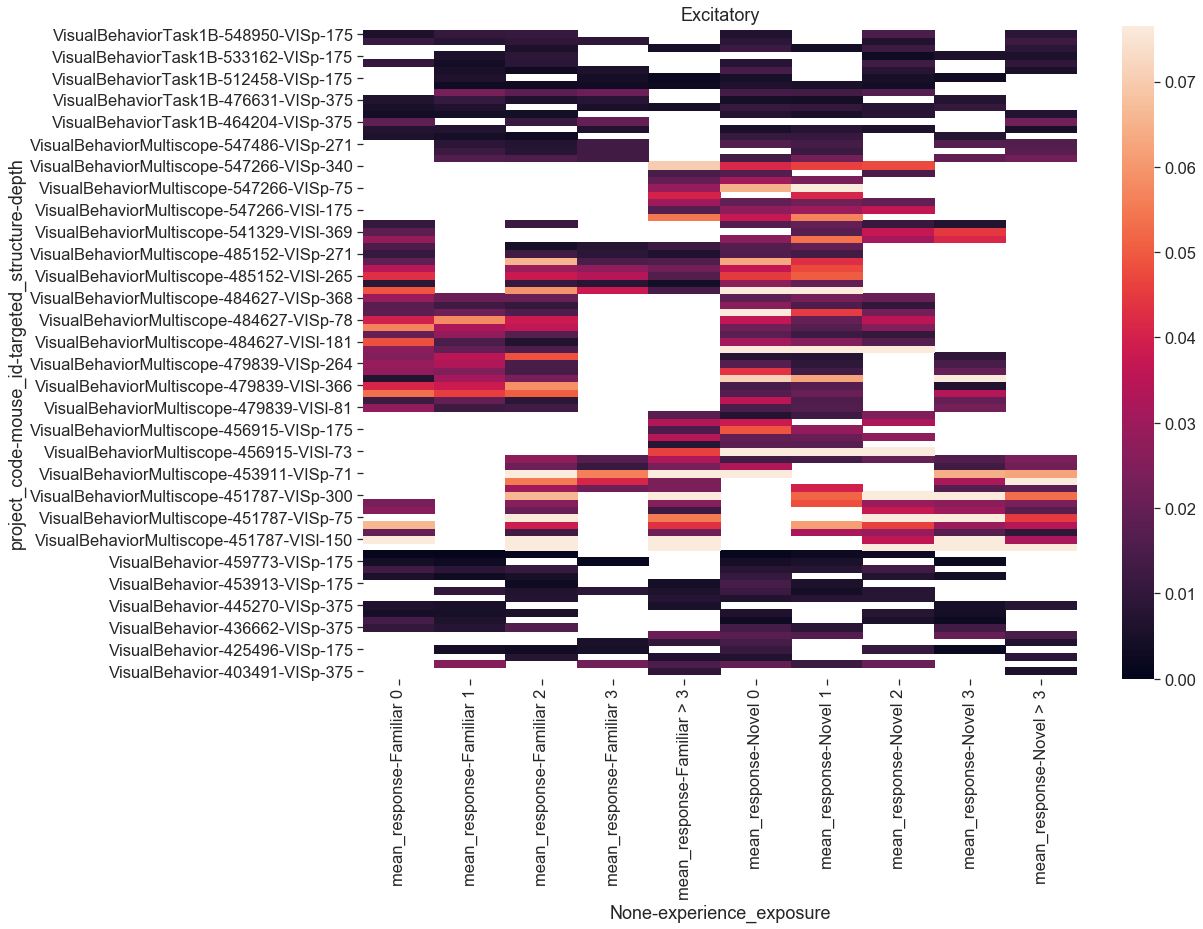

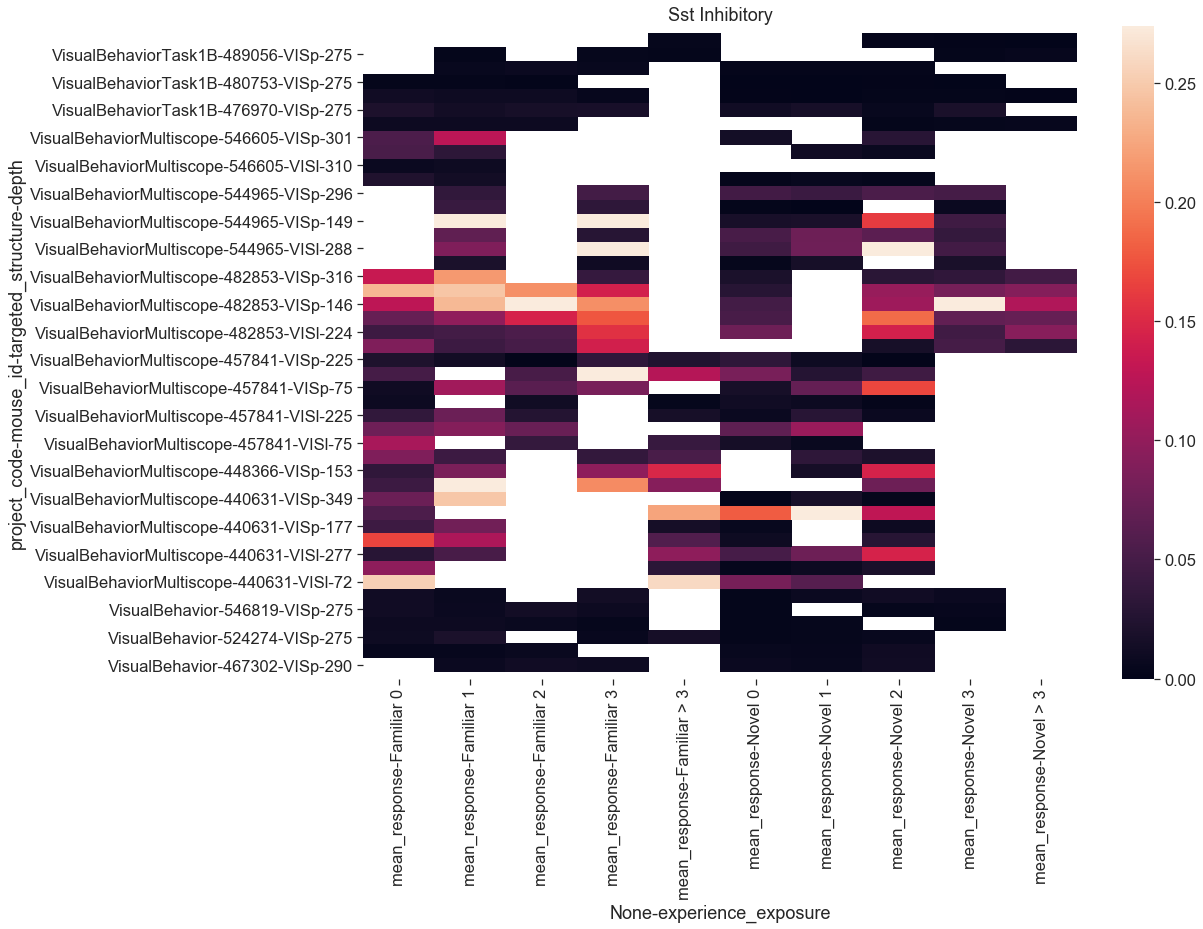

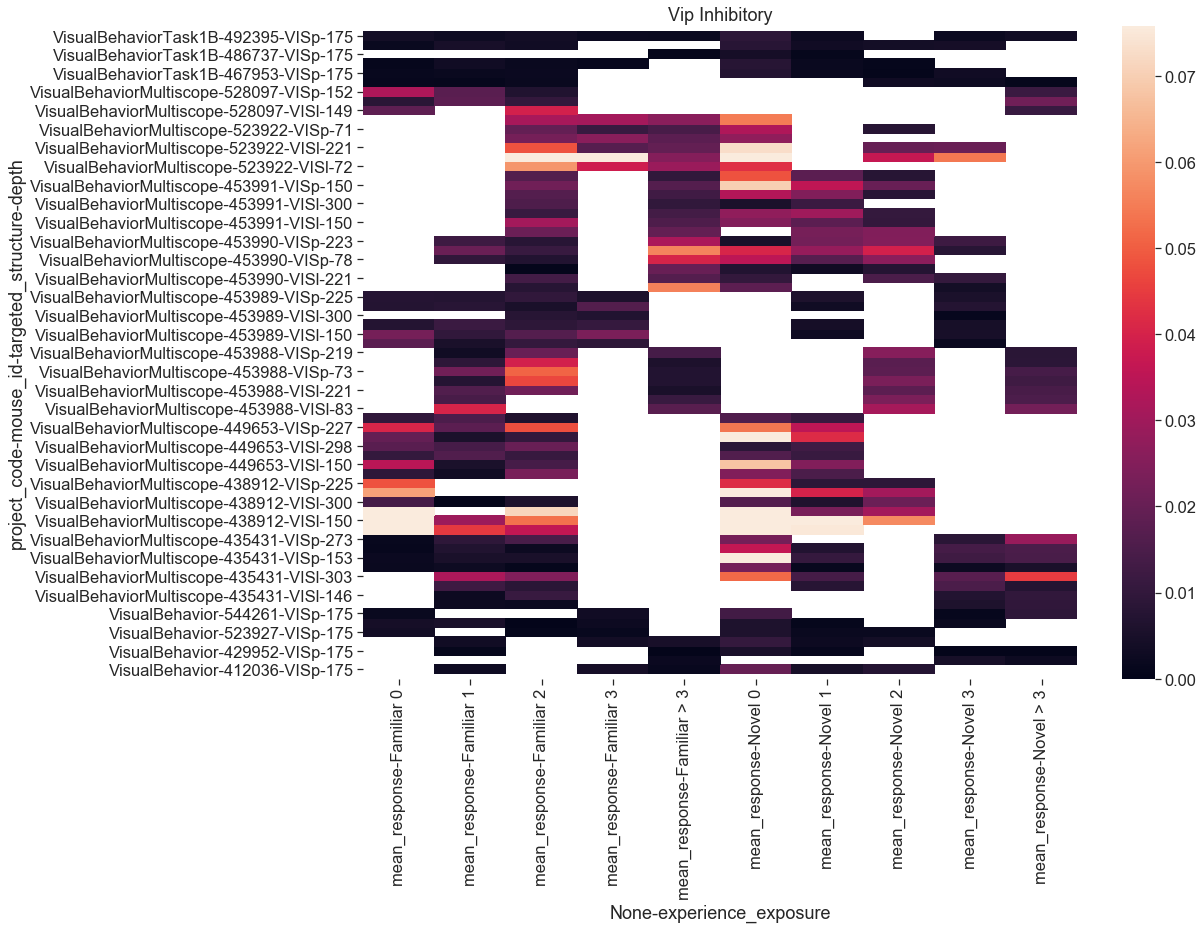

In [53]:
conditions = ['experience_exposure', 'project_code', 'mouse_id', 'targeted_structure', 'depth']
for cell_type in cell_types:
    # all mice
    data = multi_session_df.copy()
    data = data[data.cell_type==cell_type]
    data = data.sort_values(by=conditions)    
    data = data.groupby(conditions).mean()[['mean_response']].unstack(level=[0])
#     data.columns = data.columns.droplevel()
    
    fig, ax = plt.subplots(figsize=(16,12))
    ax = sns.heatmap(data, vmin=0, vmax=np.percentile(multi_session_df[multi_session_df.cell_type==cell_type].mean_response.values, 95), ax=ax)
    ax.set_title(cell_type)
    ax.set_ylim(-0.5, data.shape[0]+0.5)

In [54]:
### i

### plot population average across experience levels for Multiscope experiments

TBD: interpolate to average scientifica & multiscope

In [ ]:
os.path.join(loading.get_platform_analysis_cache_dir(), 'multi_session_summary_dfs_250ms')

In [ ]:
%%time

# set various params
df_name = 'trials_response_df'
conditions = ['cell_specimen_id', 'stimulus_change']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to changes, pref stim
multi_session_df = multi_session_df[(multi_session_df.stimulus_change==True)]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))
# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
# set project code 
project_code = 'VisualBehaviorMultiscope'

In [ ]:
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

In [ ]:
# plot
axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1.8,2.25]

df = multi_session_df[multi_session_df.project_code==project_code]
df = df[df.experience_level!='Novel >1']

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

In [ ]:
%%time

# set various params
df_name = 'trials_response_df'
conditions = ['cell_specimen_id', 'stimulus_change', 'change_image_name']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to changes, pref stim
multi_session_df = multi_session_df[(multi_session_df.stimulus_change==True)]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))
# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
# plot
project_code = 'VisualBehaviorMultiscope'
# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1.8,2.25]

df = multi_session_df[multi_session_df.project_code==project_code]
df = df[df.experience_level!='Novel >1']
df = df[df.pref_stim==True]

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

In [ ]:
%%time

# set various params
df_name = 'omission_response_df'
conditions = ['cell_specimen_id']
use_events = True
filter_events = True

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to changes, pref stim
# multi_session_df = multi_session_df[(multi_session_df.stimulus_change==True)]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))
# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
# plot
project_code = 'VisualBehaviorMultiscope'

# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1.8,2.25]

df = multi_session_df[multi_session_df.project_code==project_code]
df = df[df.experience_level!='Novel >1']

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

In [ ]:
%%time

# set various params
df_name = 'trials_response_df'
conditions = ['cell_specimen_id', 'stimulus_change']
use_events = False
filter_events = False

# load multi_session_df
multi_session_df = loading.get_multi_session_df(cache_dir, df_name, conditions, experiments_table, 
                                                use_events=use_events, filter_events=filter_events)
print(len(multi_session_df.ophys_experiment_id.unique()))

original_multi_session_df = multi_session_df.copy()

# limit to changes, pref stim
multi_session_df = multi_session_df[(multi_session_df.stimulus_change==True)]

# limit to platform paper dataset
multi_session_df = multi_session_df[multi_session_df.ophys_experiment_id.isin(experiments_table.index.values)]
print(len(multi_session_df.ophys_experiment_id.unique()))
# merge with metadata
multi_session_df = multi_session_df.merge(experiments_table, on='ophys_experiment_id')
print(len(multi_session_df.ophys_experiment_id.unique()))

In [ ]:
# plot
project_code = 'VisualBehaviorMultiscope'

# get timestamps 
multiscope_expt = experiments_table[experiments_table.project_code==project_code].index.values[9] 
timestamps = ppf.get_timestamps_for_response_df_type(cache, multiscope_expt, df_name)

axes_column = 'cell_type'
hue_column = 'experience_level'
palette = utilities.get_experience_level_colors()
xlim_seconds = [-1.8,2.25]

df = multi_session_df[multi_session_df.project_code==project_code]

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

### plot population average with exposure number 

In [ ]:
hue_column = 'prior_exposures_to_omissions'
axes_column= 'cell_type'
palette = sns.color_palette('magma',8)
xlim_seconds = [-1.8,2.25]

df = multi_session_df.copy()
df = df[df.experience_level=='Familiar']
df = df[df.prior_exposures_to_omissions<=6]

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

### plot population average across cell types

In [ ]:
axes_column = 'experience_level'
hue_column = 'cell_type'
palette = utils.get_cre_line_colors()
xlim_seconds = [-1.8,2.25]

ppf.plot_population_averages_for_conditions(df, df_name, timestamps, 
                                            axes_column, hue_column, project_code=project_code,
                                            use_events=use_events, filter_events=filter_events, 
                                            xlim_seconds=xlim_seconds, palette=palette,
                                            horizontal=True, save_dir=None, folder=None)

### plot cell response heatmaps

In [ ]:
matched_cells = pd.read_csv(r"\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\matched_cell_lists\cells_matched_across_experience_levels_full_dataset.csv")
matched_cell_ids = matched_cells.cell_specimen_id.unique()

In [ ]:
sdf = multi_session_df.copy()
# sdf = sdf[sdf.cell_specimen_id.isin(matched_cell_ids)]
sdf = sdf.sort_values(by='date_of_acquisition', ascending=True)
sdf = sdf.drop_duplicates(subset=['cell_specimen_id', 'experience_level'], keep='first') 

row_condition = 'cell_type'
col_condition = 'experience_level'
xlim_seconds = [(3-1.8)*11,(3+2.25)*11]

ppf.plot_response_heatmaps_for_conditions(sdf, df_name, timestamps,
                                        row_condition, col_condition, use_events, filter_events, project_code=project_code,
                                        microscope='Multiscope', vmax=0.04, xlim_seconds=xlim_seconds, 
                                        match_cells=True, save_dir=None, folder=None)